In [1]:
from ase.atoms import Atoms
from ase.build import bulk as _bulk

In [2]:
from atomistics.workflows import (
    optimize_positions_and_volume as _optimize_positions_and_volume,
)
from atomistics.workflows.evcurve.helper import (
    analyse_structures_helper,
    generate_structures_helper,
)
from atomistics.calculators import (
    evaluate_with_lammpslib as _evaluate_with_lammpslib, 
    get_potential_by_name as _get_potential_by_name,
)

In [3]:
import pandas

In [4]:
from pyiron_workflow import as_function_node, Workflow

In [5]:
@as_function_node
def bulk(name: str, cubic: bool = False) -> Atoms:
    return _bulk(name=name, cubic=cubic)

In [6]:
@as_function_node
def get_potential_by_name(potential_name: str) -> pandas.Series:
    return _get_potential_by_name(potential_name=potential_name)

In [7]:
@as_function_node
def optimize_positions_and_volume(structure: Atoms) -> dict:
    return _optimize_positions_and_volume(structure=structure)

In [8]:
@as_function_node
def evaluate_with_lammpslib(task_dict: dict, potential_dataframe: pandas.Series) -> dict:
    return _evaluate_with_lammpslib(task_dict=task_dict, potential_dataframe=potential_dataframe)

In [9]:
@as_function_node
def evcurve_generate_structures(structure: dict, vol_range: float, num_points: int) -> dict:
    return {
        "calc_energy": generate_structures_helper(
            structure=structure["structure_with_optimized_positions_and_volume"],
            vol_range=vol_range,
            num_points=num_points,
        ),
    }

In [10]:
@as_function_node
def evcurve_analyse_structures(output_dict: dict, structure_dict: dict, fit_type: str = "polynomial", fit_order: int = 3) -> dict:
    return analyse_structures_helper(
        output_dict=output_dict,
        structure_dict=structure_dict["calc_energy"],
        fit_type=fit_type,
        fit_order=fit_order,
    )

In [11]:
wf = Workflow(label="evcurve")

In [12]:
wf.structure = bulk("Al", cubic=True)

In [13]:
wf.df_pot_selected = get_potential_by_name(
    potential_name="1999--Mishin-Y--Al--LAMMPS--ipr1",
)

In [14]:
wf.opt_task_dict = optimize_positions_and_volume(structure=wf.structure)

In [15]:
wf.opt_result_dict = evaluate_with_lammpslib(
    task_dict=wf.opt_task_dict,
    potential_dataframe=wf.df_pot_selected,
)

In [16]:
wf.structure_dict = evcurve_generate_structures(
    structure=wf.opt_result_dict,
    vol_range=0.05,
    num_points=11,
)

In [17]:
wf.result_dict = evaluate_with_lammpslib(
    task_dict=wf.structure_dict,
    potential_dataframe=wf.df_pot_selected,
)

In [18]:
wf.fit_dict = evcurve_analyse_structures(
    output_dict=wf.result_dict,
    structure_dict=wf.structure_dict,
    fit_type="polynomial",
    fit_order=3,
)
wf.fit_dict.pull()

/srv/conda/envs/notebook/lib/python3.12/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


{'b_prime_eq': 1.2795467367535456,
 'bulkmodul_eq': 77.72501703076111,
 'volume_eq': 66.43019790724618,
 'energy_eq': -13.439968044042756,
 'fit_dict': {'fit_type': 'polynomial',
  'least_square_error': 3.2251566930530093e-10,
  'poly_fit': array([-4.17653947e-05,  1.19748123e-02, -1.03804985e+00,  1.49171027e+01]),
  'fit_order': 3},
 'energy': [-13.398175054706176,
  -13.4133940159381,
  -13.425115937672244,
  -13.433413658516757,
  -13.438358754759525,
  -13.439999952735112,
  -13.438382355644501,
  -13.433605756604651,
  -13.42577121684493,
  -13.41495739484744,
  -13.401227593921192],
 'volume': [63.10883669478296,
  63.77314023893856,
  64.43744378309412,
  65.10174732724975,
  65.7660508714054,
  66.43035441556098,
  67.09465795971657,
  67.7589615038722,
  68.42326504802779,
  69.08756859218344,
  69.75187213633905]}

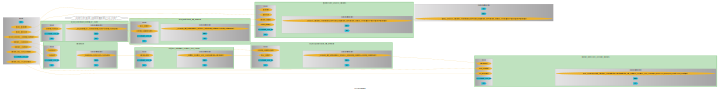

In [19]:
wf.draw(size=(10,10))